In [23]:

%load_ext autoreload
%autoreload 2
import numpy as np, pandas as pd
import joblib, os
from scipy.signal import spectrogram
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
from lfp.lfpFunctions import *
from lfp.readLFP import *
from lfp.EMGFromLFP import *

animal= 'Both_front'
test_paths = [f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/p10',
              f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/p16']
days = [os.path.basename(path) for path in test_paths]
p10_path, p16_path = test_paths[0], test_paths[1]
p10_dataclass = joblib.load(f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/{days[0]}/{days[0]}_dataclass.joblib')
p16_dataclass = joblib.load(f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/{days[1]}/{days[1]}_dataclass.joblib')
p10_state_df = p10_dataclass.make_state_df(paw_data=True, motion_indices={'motion':1, 'left_paw': 2, 'right_paw':1})
p16_state_df = p16_dataclass.make_state_df(paw_data=True, motion_indices={'motion':1, 'left_paw': 2, 'right_paw':1})
p10_lfp_file = f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/{days[0]}/{days[0]}.lfp'
p16_lfp_file = f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/{days[1]}/{days[1]}.lfp'
p10_lfp = load_lfp(p10_lfp_file, num_channels=1)
p16_lfp = load_lfp(p16_lfp_file, num_channels=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Facemap motion signal contains 37442 frames, camera captured 37445 frames.
Threshold for signal 32.13465411063628
motion_bool True ratio: 0.20675657631192415
Getting paw data....
Threshold for signal -0.013882786910264816
Got data for left paw!
Threshold for signal 0.003936934907122888
Got data for right paw!
Adding left paw data
Facemap motion signal contains 20913 frames, camera captured 20916 frames.
Threshold for signal 106.70575669287597
motion_bool True ratio: 0.2472748135398738
Getting paw data....
Threshold for signal -0.021067867422063947
Got data for left paw!
Threshold for signal -0.004547953692914942
Got data for right paw!
Adding left paw data


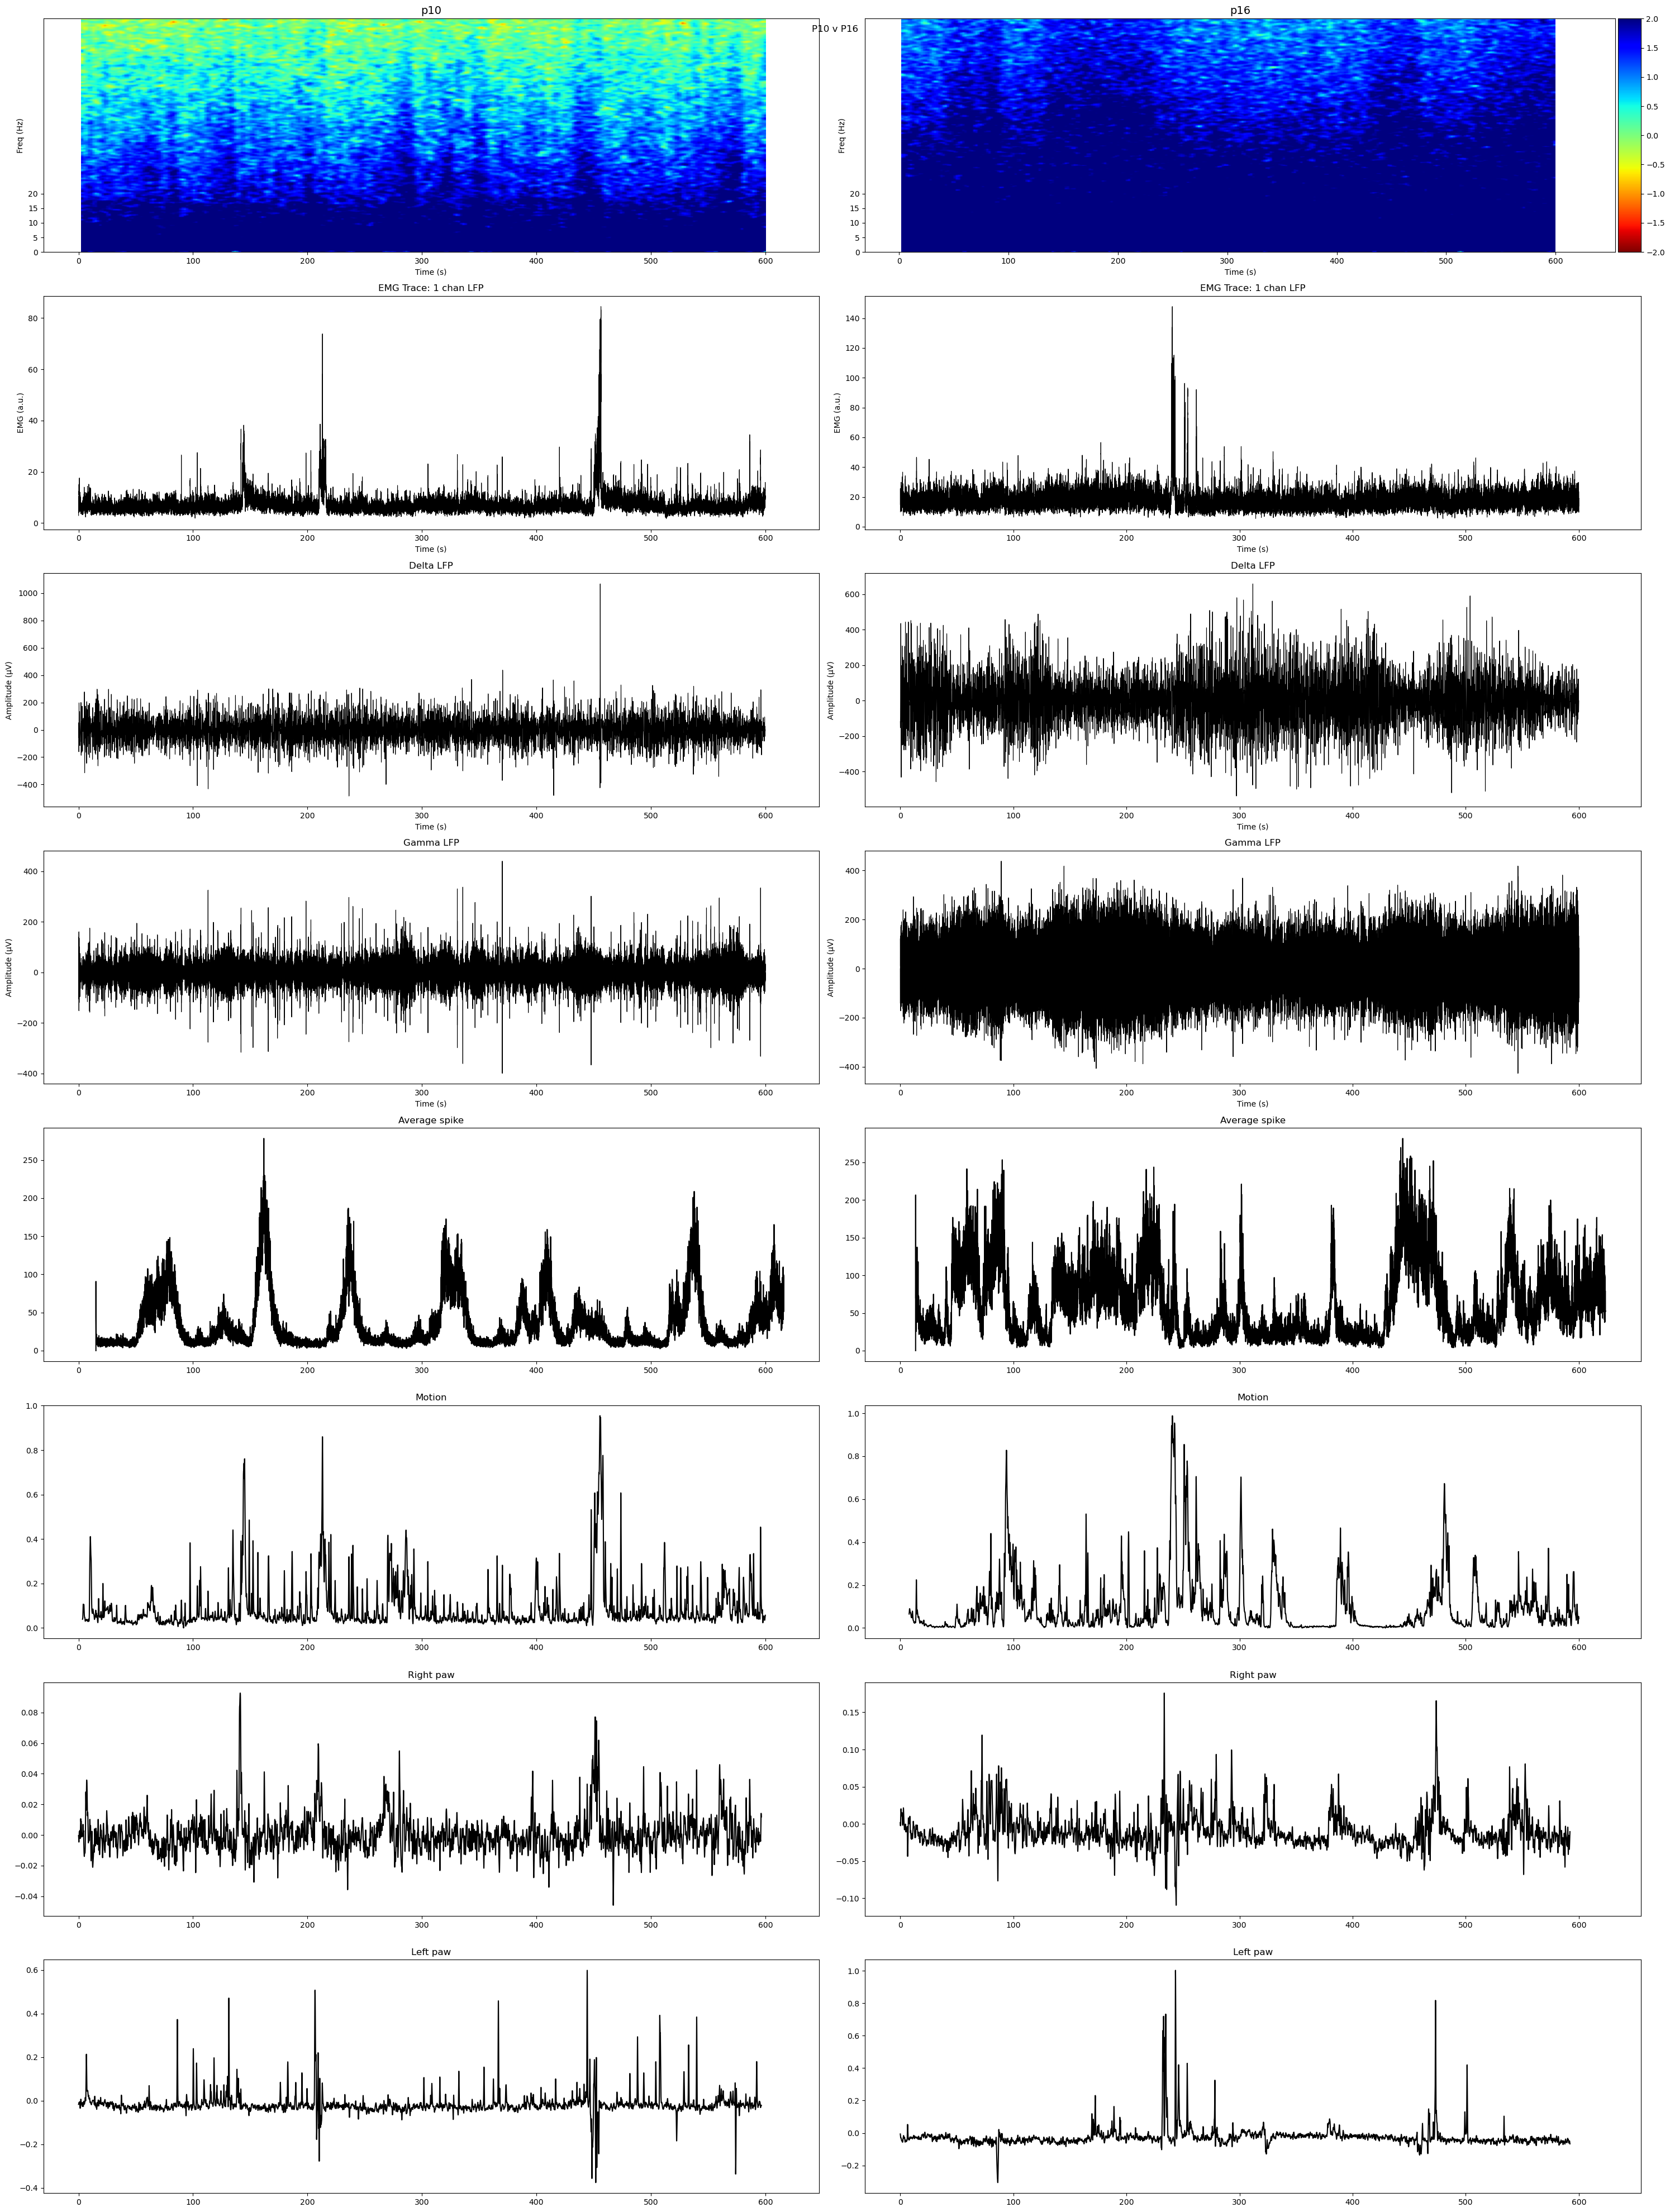

In [25]:
%autoreload 2
from lfp.LFPPlots import *
def emg_multiplot(dataclasses, lfps, state_dfs,
                   suptitle=None, col_titles=[], start=0, end=None, scope_fs=30, cam_fs= 30):
    fig, axs = plt.subplots(8, len(dataclasses),
                             figsize=(30, 40))
    rec_idx = 0
    if suptitle:
        plt.suptitle(suptitle)
    if col_titles:
        for ax, title in zip(axs[0], col_titles):
            ax.set_title(title, fontsize=14)

    for col in range(axs.shape[1]):
        master = axs[0, col]
        for row in range(1, axs.shape[0]):
            axs[row, col].sharex(master)

    for dataclass in dataclasses:
        suite2p_out = dataclass.s2p_out
        spike_train = np.nanmean(suite2p_out.get_cell_spikes(), axis=0) 
        if scope_fs is None:
            scope_fs = suite2p_out.scope_fs
        if end is None:
            end = suite2p_out.F.shape[1] / scope_fs
        frametimes = dataclass.scope_times
        #     print(end, suite2p_out.scope_fs)
        time, freq, spec = compute_spectrogram(lfps[rec_idx], fs=1250)

        #if rec_idx == len(dataclasses) - 1:
        ax_spec, im = plot_buzcode_style_spectrogram(time, freq, spec, t_start=0, t_end=600,
                            time_sigma=1, freq_sigma=1, axs=axs[0, rec_idx], colorbar=False)
        if rec_idx == len(dataclasses) - 1:
            from mpl_toolkits.axes_grid1 import make_axes_locatable
            # Create a colorbar axis *without shifting the main axis*
            divider = make_axes_locatable(ax_spec)
            cax = divider.append_axes("right", size="3%", pad=0.05)
            fig.colorbar(im, cax=cax)
        ax_spec.set_ylabel("Freq (Hz)")
        ax_spec.set_xlabel("Time (s)")
        ax_spec.tick_params(labelbottom=True)
        ax_spec.set_xlabel("Time (s)")

        plot_emg_from_lfp(
        lfps[rec_idx],
        fs=1250,
        lowcut=100.0,
        highcut=250.0,
        smooth_win=0.05,
        agg="median",
        t_start=start,
        t_end=end,
        downsample=1,
        ax=axs[1,rec_idx],
        title="EMG Trace: 1 chan LFP")

        plot_delta_lfp(lfps[rec_idx], fs=1250, ax=axs[2, rec_idx],
                        t_start=start, t_end=end, color='black')
        axs[2, rec_idx].set_title('Delta LFP')

        plot_gamma_lfp(lfps[rec_idx], fs=1250, ax=axs[3, rec_idx], t_start=start, t_end=end,
                       color='black')
        axs[3, rec_idx].set_title('Gamma LFP')

        state_df = state_dfs[rec_idx]
        state_df = state_df[(state_df['time'] >= start) & (state_df['time'] <= end)]
        trace_start, trace_end = int(start*scope_fs), int(end*scope_fs)

        axs[4, rec_idx].plot(frametimes[trace_start:trace_end],
                              spike_train[:-1][trace_start: trace_end], color='black')
        axs[4, rec_idx].set_title('Average spike')

        axs[5, rec_idx].plot(state_df['time'],
                              state_df['motion'], color='black')
        axs[5, rec_idx].set_title('Motion')

        axs[6, rec_idx].plot(np.arange(len(state_df)) / 30,
                              state_df['right_paw'], color='black')
        axs[6, rec_idx].set_title('Right paw')

        axs[7, rec_idx].plot(np.arange(len(state_df)) / 30,
                              state_df['left_paw'], color='black')
        
        axs[7, rec_idx].set_title('Left paw')
        rec_idx += 1
    
    plt.tight_layout()
    plt.show()
    
emg_multiplot([p10_dataclass, p16_dataclass], lfps=[p10_lfp, p16_lfp],
               state_dfs=[p10_state_df, p16_state_df], scope_fs = 30,
               start=0, end=600,
                 suptitle='P10 v P16', col_titles=['p10', 'p16'])


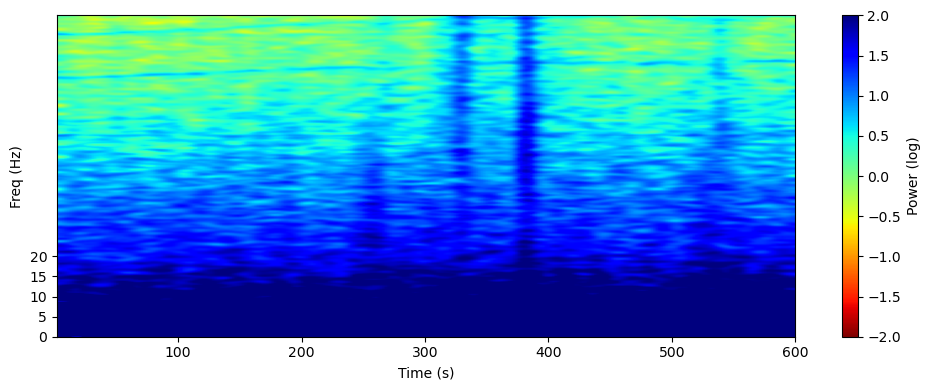

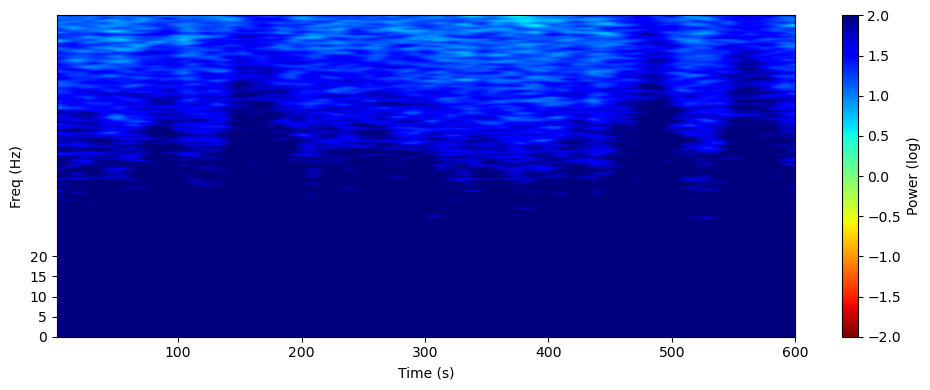

In [5]:
from lfp.LFPPlots import plot_buzcode_style_spectrogram
p10_time, p10_freq, p10_spec = compute_spectrogram(p10_lfp, fs=1250)
#p10_time_test, p10_freq_test, p10_spec_test = compute_spectrogram(load_lfp('p10_old.lfp', num_channels=1), fs=1250)
p16_time, p16_freq, p16_spec = compute_spectrogram(p16_lfp, fs=1250)

plot_buzcode_style_spectrogram(p10_time, p10_freq, p10_spec, t_start=0, t_end=600,
                               time_sigma=3, freq_sigma=1)
#plot_buzcode_style_spectrogram(p10_time_test, p10_freq_test, p10_spec_test, time_sigma=1, freq_sigma=1)
plot_buzcode_style_spectrogram(p16_time, p16_freq, p16_spec, t_start=0, t_end=600,
                               time_sigma=3, freq_sigma=1)

In [21]:
import h5py
f = h5py.File("/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p10/p10.SleepState.states.mat")
f["SleepState"]["detectorinfo"]["StatePlotMaterials"].keys()


<KeysViewHDF5 ['IRASAintercept', 'IRASAslope', 'IRASAsmooth', 'IRASAsmooth_th', 'swFFTfreqs', 'swFFTspec', 't_clus', 'thFFTfreqs', 'thFFTspec', 'thFFTspec_raw']>